In [ ]:
import pandas as pd

df = pd.read_csv("Jumlah_Kasus_HIV_AIDS_Jayapura_2023_clean.csv")

df.head(5) 


,Wilayah,HIV,AIDS,Jumlah,Mati
0,Kota Jayapura,3206,4747,7953,375
1,Provinsi Papua,21947,30846,52793,3735


In [ ]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Wilayah  2 non-null      object
 1   HIV      2 non-null      int64 
 2   AIDS     2 non-null      int64 
 3   Jumlah   2 non-null      int64 
 4   Mati     2 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 212.0+ bytes
None
                HIV          AIDS        Jumlah         Mati
count      2.000000      2.000000      2.000000     2.000000
mean   12576.500000  17796.500000  30373.000000  2055.000000
std    13251.888186  18454.779882  31706.668068  2375.878785
min     3206.000000   4747.000000   7953.000000   375.000000
25%     7891.250000  11271.750000  19163.000000  1215.000000
50%    12576.500000  17796.500000  30373.000000  2055.000000
75%    17261.750000  24321.250000  41583.000000  2895.000000
max    21947.000000  30846.000000  52793.000000  3735.000000


>> Nilai unik kolom 'wilayah' (normalized):
['kota jayapura' 'provinsi papua']


Numeric columns yang akan dianalisis: ['hiv', 'aids', 'jumlah', 'mati']

Kontribusi Jayapura terhadap Papua (persen):
hiv       14.61
aids      15.39
jumlah    15.06
mati      10.04
dtype: float64


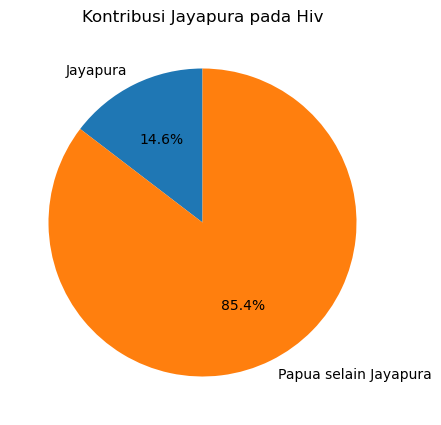

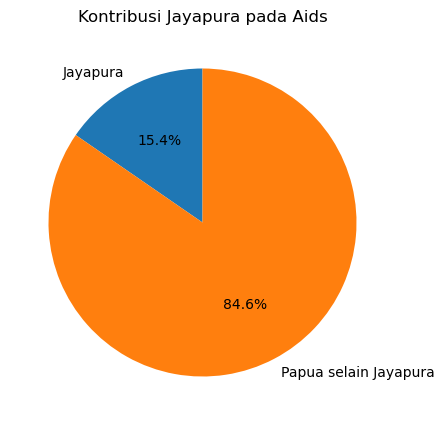

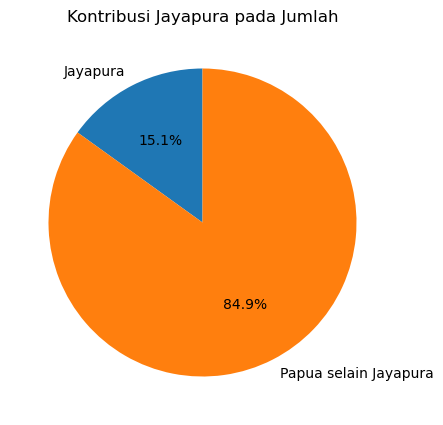

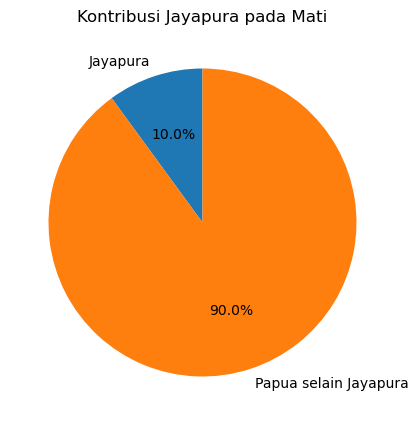

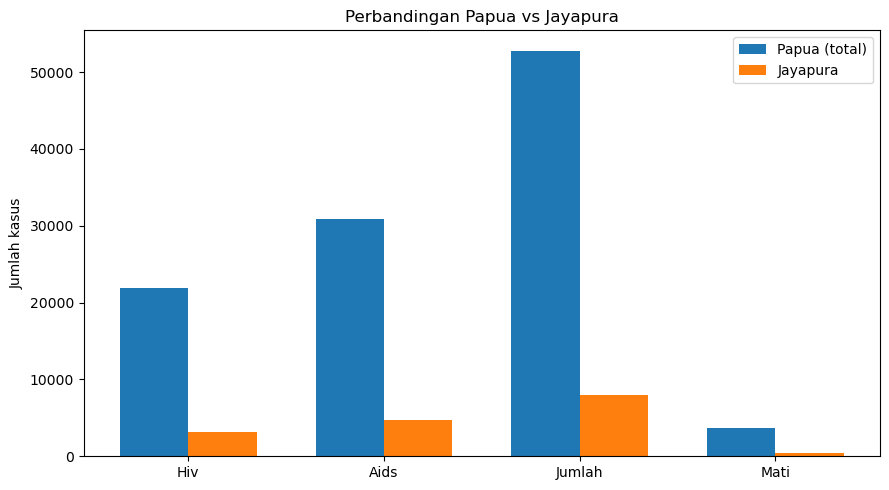

In [ ]:
import re
import matplotlib.pyplot as plt
# 1) Normalisasi nama kolom & nilai wilayah
df.columns = df.columns.str.strip().str.lower()    # contoh: "Wilayah" -> "wilayah"
if 'wilayah' not in df.columns:
    print("ERROR: Kolom 'Wilayah' tidak ditemukan. Kolom yang ada:", df.columns.tolist())
else:
    df['wilayah_norm'] = df['wilayah'].astype(str).str.strip().str.lower()
    print(">> Nilai unik kolom 'wilayah' (normalized):")
    print(df['wilayah_norm'].unique())
    print()

    # 2) Fungsi bantu: cari baris region secara toleran
    def pick_region(df, name):
        name = name.lower().strip()
        # exact match
        exact = df[df['wilayah_norm'] == name]
        if len(exact) == 1:
            return exact.iloc[0]
        contains = df[df['wilayah_norm'].str.contains(re.escape(name), na=False)]
        if len(contains) == 1:
            return contains.iloc[0]
        pattern = rf'\b{re.escape(name)}\b'
        wb = df[df['wilayah_norm'].str.contains(pattern, regex=True, na=False)]
        if len(wb) == 1:
            return wb.iloc[0]
        if len(contains) > 1 or len(wb) > 1:
            candidates = (wb if len(wb) > 0 else contains)
            print(f"Warning: banyak kandidat untuk '{name}':", candidates['wilayah_norm'].tolist())
            print("=> Aku pilih kandidat pertama supaya proses lanjut. Kalau salah, pilih manual.")
            return candidates.iloc[0]
        # tidak ditemukan
        return None

    papua_row = pick_region(df, 'papua')
    jayapura_row = pick_region(df, 'jayapura')

    if papua_row is None or jayapura_row is None:
        print("\nGagal menemukan salah satu wilayah. Periksa daftar wilayah unik di atas.")
        print("\nIsi tabel (preview 20 baris) untuk inspeksi manual:")
        display(df.head(20))
    else:
        # 4) Ambil kolom numerik untuk analisis
        numeric_cols = df.select_dtypes(include='number').columns.tolist()
        if not numeric_cols:
            print("Tidak ada kolom numerik yang ditemukan. Kolom tersedia:", df.columns.tolist())
        else:
            print("\nNumeric columns yang akan dianalisis:", numeric_cols)

            pap_vals = papua_row[numeric_cols].astype(float)
            jay_vals = jayapura_row[numeric_cols].astype(float)

            # 5) Hitung kontribusi (persen), aman terhadap pembagian nol
            contrib = (jay_vals / pap_vals.replace({0: pd.NA})) * 100
            print("\nKontribusi Jayapura terhadap Papua (persen):")
            print(contrib.round(2))

            # 6) Visualisasi: Pie chart untuk tiap kolom numerik
            for col in numeric_cols:
                p_total = pap_vals[col]
                j_val = jay_vals[col]
                other = p_total - j_val
                if pd.isna(p_total) or p_total == 0:
                    print(f"Skip pie untuk '{col}' karena total Papua = {p_total}")
                    continue
                if other < 0:
                    print(f"Warning: nilai Jayapura ({j_val}) > total Papua ({p_total}) untuk kolom {col}. Skipping pie.")
                    continue

                labels = ['Jayapura', 'Papua selain Jayapura']
                sizes = [j_val, other]

                plt.figure(figsize=(5,5))
                plt.pie(sizes, labels=labels, autopct='%.1f%%', startangle=90)
                plt.title(f"Kontribusi Jayapura pada {col.title()}")
                plt.show()

            # 7) Visualisasi: Bar chart perbandingan Papua vs Jayapura
            x = range(len(numeric_cols))
            pap_list = [pap_vals[c] for c in numeric_cols]
            jay_list = [jay_vals[c] for c in numeric_cols]

            plt.figure(figsize=(9,5))
            width = 0.35
            plt.bar([i - width/2 for i in x], pap_list, width=width, label='Papua (total)')
            plt.bar([i + width/2 for i in x], jay_list, width=width, label='Jayapura')
            plt.xticks(x, [c.title() for c in numeric_cols])
            plt.ylabel('Jumlah kasus')
            plt.title('Perbandingan Papua vs Jayapura')
            plt.legend()
            plt.tight_layout()
            plt.show()
